# LangGraph Basics - Building a Simple Math Agent

## Step 1: Import dependencies and initialize the LLM

In [1]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"var: ")

_set_env("OPENAI_API_KEY")

In [2]:
from langchain_core.tools import tool
from langchain.chat_models import init_chat_model

llm = init_chat_model(
    "openai:gpt-5-mini",
)

## Step 2: Define tools for arithmetic operations

In [3]:
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

## Step 3: Bind tools to the LLM

In [4]:
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [5]:
output_function_call = llm_with_tools.invoke("Add 3 and 4 using the add tool")
output_function_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9KUXa6EtW6Jdl9x0sq7MgSxw', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 219, 'total_tokens': 245, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-D7idfKkTU4iuHbZWqmG5M6D7nTVoQ', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-967b2a87-39f8-41c3-9f30-9d260d38be74-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'call_9KUXa6EtW6Jdl9x0sq7MgSxw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 219, 'output_tokens': 26, 'total_tokens': 245, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio':

In [6]:
output_function_call.additional_kwargs['tool_calls'][0]['function']['name']

'add'

In [7]:
output_function_call.additional_kwargs['tool_calls'][0]['function']['arguments']

'{"a":3,"b":4}'

## Step 4: Define the agent state

In [8]:
# from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

## Step 5: Define the LLM node

In [9]:
from langchain_core.messages import SystemMessage

def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

## Step 6: Define the tool execution node

In [10]:
from langchain_core.messages import ToolMessage

def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

## Step 7: Define the conditional routing logic

In [11]:
from typing import Literal
from langgraph.graph import StateGraph, START, END

def route_between_nodes(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, we stop (reply to the user)
    return END

## Step 8: Build the agent graph

In [12]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    route_between_nodes,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

## Step 9: Visualize the agent graph

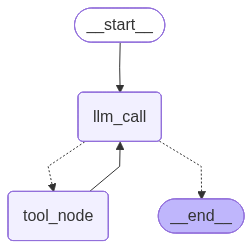

In [13]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

## Step 10: Run the agent with a sample query

In [14]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="Multiply 200 by 2 then \
    divide the result by 100")]
messages = agent.invoke({"messages": messages})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Multiply 200 by 2 then     divide the result by 100
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Ubo2WGVSzs2bG6dXh92LP55d)
 Call ID: call_Ubo2WGVSzs2bG6dXh92LP55d
  Args:
    a: 200
    b: 2
================================= Tool Message =================================

400
================================== Ai Message ==================================
Tool Calls:
  divide (call_tqK2vyHk0HwNneVGemWHasRM)
 Call ID: call_tqK2vyHk0HwNneVGemWHasRM
  Args:
    a: 400
    b: 100
================================= Tool Message =================================

4.0
================================== Ai Message ==================================

4.0


In [15]:
from langgraph.prebuilt import create_react_agent
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """Adds a and b."""
    return a + b

llm = init_chat_model(
    "openai:gpt-5-mini")

agent = create_react_agent(
    model=llm,
    tools=[add])

agent.invoke({"messages": [HumanMessage(content="Add 3 and 4.")]})

{'messages': [HumanMessage(content='Add 3 and 4.', additional_kwargs={}, response_metadata={}, id='d62c26dc-3b4b-4f6f-ae6b-7717891935d6'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_edsv0yWnSsOSrUYy2B4b1Ame', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 133, 'total_tokens': 223, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-D7idooDJu0Auqgtx4LZfxhbeN20B9', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-153df981-e604-4f72-9092-605124831034-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'call_edsv0yWnSsOSrUYy2B4b1Ame', 'type': 'tool_call'}], usage_metadata={'input_t

In [16]:

@tool
def multiply(a: int, b: int) -> int:
    """Multiplies a and b."""
    return a * b

agent_2 = create_react_agent(
    model=llm,
    tools=[multiply],
)

agent_2.invoke({"messages": [HumanMessage(content="Multiply 200 by 2")]})

{'messages': [HumanMessage(content='Multiply 200 by 2', additional_kwargs={}, response_metadata={}, id='99218494-a50f-47ad-acc2-575489d7c56a'),
  AIMessage(content='200 × 2 = 400', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 134, 'total_tokens': 214, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-D7idtHcdmdS7Vz5J00oMZJWyPybFq', 'finish_reason': 'stop', 'logprobs': None}, id='run-2e81b5f8-c56e-4b5a-94aa-25055b9fee3c-0', usage_metadata={'input_tokens': 134, 'output_tokens': 80, 'total_tokens': 214, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 64}})]}

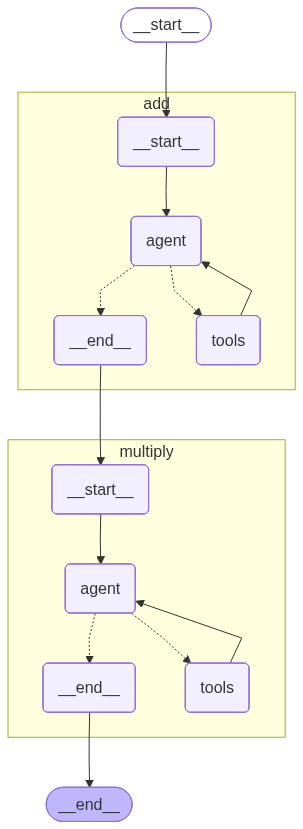

In [18]:
from langgraph.graph import StateGraph, END

# Define a simple state class to hold the running value
class CalcState(dict):
    pass

# Node for add agent
def add_node(state: CalcState):
    # expects state["messages"] to be present
    result = agent.invoke({"messages": state["messages"]})
    # get the output value from the agent's response
    # The agent returns a list of messages, the last one is the AIMessage
    # For this example, let's extract the tool call result from the message
    # We'll just pass the messages along for the next agent
    return {"messages": result["messages"]}

# Node for multiply agent
def multiply_node(state: CalcState):
    result = agent_2.invoke({"messages": state["messages"]})
    return {"messages": result["messages"]}

# Build the graph
graph = StateGraph(CalcState)
graph.add_node("add", agent)
graph.add_node("multiply", multiply_node)

# For this example, let's go from add -> multiply -> END
graph.add_edge("add", "multiply")
graph.add_edge("multiply", END)

# Set the entry point
graph.set_entry_point("add")

# Compile the graph
compiled_graph = graph.compile()

Image(compiled_graph.get_graph(xray=True).draw_mermaid_png())